In [1]:
import mindspore.dataset as ds
from mindvision.dataset import Mnist
import mindspore as ms

In [2]:
download_train = Mnist(path="data/MNIST/raw", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=False)
download_eval = Mnist(path="data/MNIST/raw", split="test", batch_size=32, resize=32, download=False)
dataset_train = download_train.run()
dataset_eval = download_eval.run()

[WARNING] ME(20252:21188,MainProcess):2023-05-04-19:10:21.197.986 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(20252:21188,MainProcess):2023-05-04-19:10:21.200.993 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20252:21188,MainProcess):2023-05-04-19:10:21.200.993 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20252:21188,MainProcess):2023-05-04-19:10:21.201.991 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

In [3]:
count = 0
for i in dataset_train:
    count += 1
    print(i[1])
    print(type(i[1]))
    print(i[0].shape)
    if count == 1:
        break

[4 9 3 4 6 3 7 3 6 2 6 8 2 9 2 0 9 0 8 2 8 4 2 4 6 8 1 0 8 8 6 8]
<class 'mindspore.common.tensor.Tensor'>
(32, 1, 32, 32)


In [4]:
from mindspore import nn

In [5]:
class AE(nn.Cell):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.SequentialCell(
            nn.Dense(32*32, 256),
            nn.ReLU(),
            nn.Dense(256, 64),
            nn.ReLU(),
            nn.Dense(64, 20),
            nn.ReLU()
        )

        self.decoder = nn.SequentialCell(
            nn.Dense(20, 64),
            nn.ReLU(),
            nn.Dense(64, 256),
            nn.ReLU(),
            nn.Dense(256, 32*32),
            nn.Sigmoid()
        )

    def construct(self, x):
        batch_size = 32
        x = x.view(batch_size, 32*32)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(batch_size, 1, 32, 32)
        return x


In [6]:
net = AE()
print(net)
loss_function = nn.MSELoss()
opt = nn.Adam(net.trainable_params(), learning_rate=0.001)

AE<
  (encoder): SequentialCell<
    (0): Dense<input_channels=1024, output_channels=256, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=256, output_channels=64, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=64, output_channels=20, has_bias=True>
    (5): ReLU<>
    >
  (decoder): SequentialCell<
    (0): Dense<input_channels=20, output_channels=64, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=64, output_channels=256, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=256, output_channels=1024, has_bias=True>
    (5): Sigmoid<>
    >
  >


In [7]:
import numpy as np

In [10]:
with_loss = nn.WithLossCell(net, loss_function)
train_step = nn.TrainOneStepCell(with_loss, opt).set_train()

In [11]:
import tqdm

In [12]:
for epoch in range(5):
    for x_train, _ in tqdm.tqdm(dataset_train):
        loss = train_step(x_train, x_train)
    print('epoch: {0}, loss is {1}'.format(epoch, loss))

1875it [00:41, 44.65it/s]


epoch: 0, loss is 0.5560311


1875it [01:13, 25.53it/s]


epoch: 1, loss is 0.48557654


1875it [01:55, 16.24it/s]


epoch: 2, loss is 0.46278352


205it [00:15, 13.12it/s]


KeyboardInterrupt: 

(-0.5, 31.5, 31.5, -0.5)

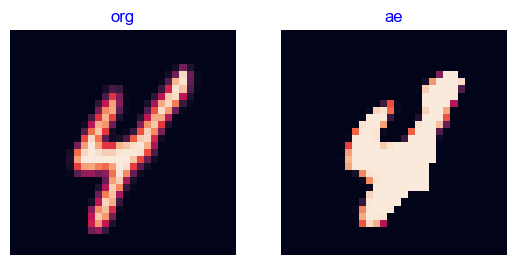

In [16]:
import matplotlib.pyplot as plt
count = 0
for x_eval, _ in dataset_eval:
    if count == 1:
        break
x_hat = net(x_eval)

x_eval1 = x_eval[0].asnumpy()
x_hat1 = x_hat[0].asnumpy()

plt.subplot(1, 2, 1)
plt.title("org", color='blue')
plt.imshow(np.squeeze(x_eval1))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("ae", color='blue')
plt.imshow(np.squeeze(x_hat1))
plt.axis("off")